In [3]:
push!(LOAD_PATH, pwd()) # put current directory on path
using Revise
using UnPack
#include("ModelHelperFuns.jl")  # load the file
#using .ModelHelperFuns         # bring the module into scope
using CooperativeHuntingPkg
using Plots
default(
    guidefontsize=14,   # controls xlabel, ylabel, title font size
    tickfontsize=12,    # controls axis number labels
    legendfontsize=14,  # controls legend font
    linewidth=2,        # controls default line thickness
    grid = false,        # turns off grid in background
    fontfamily="Computer Modern", # font family that matches latex
    dpi = 200
)
using LaTeXStrings
using BifurcationKit, DifferentialEquations
# pgfplotsx()  # Set PGFPlotsX as the backend # this seems to not work on my computer, or on vscode.
using Measures # helps for adjusting location of axis labels
bif_fig_path = "/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"

"/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"

In [31]:
function consecutive_runs(idx::Vector{Int})
    isempty(idx) && return UnitRange{Int}[] # check if idx is empty
    b = findall(diff(idx) .> 1) # diff gives the difference between the ith and i - 1 entry. find places where not consecutive

    # segments are the values corresponding to idx from (1)1 to the first entry of b, 
        # (2) the first entry of b + 1 to the 2nd entry of b, 
        # etc...
    starts = [1; b .+ 1]
    ends   = [b; length(idx)]
    [idx[s]:idx[e] for (s,e) in zip(starts, ends)]
end
function plot_STABLE_lines(branches; y2lims = [0,2.5], legendloc = :right, twinx = true)
    """
    Plot P, N1, N2 at the stable coexistence equilibrium
                OR ACTUALLY AT THE STABLE EQUILIBRIUM, DOES NOT HAVE TO BE COEXISTENCE
    Two y axes (one for prey, one for predators)
    """
    plt_N = plot()
    branches = (branches isa Union{AbstractArray,NamedTuple}) ? branches : [branches]

    plot!(ylab = L"Prey Density, $N_i$",
                    xlab = "\n"*"Group Size, "*L"x",
                    bottommargin = 5mm,
                    guidefontsize=20,
                    legend = legendloc,
                    )#ylab = "Scaled Prey Density\nat Equilibrium"
    if twinx == true
        plot!(ylims = [-0.05,1.05])
    end       
    param_vecs = []
    N1_vecs = []
    N2_vecs = [] 
    P_vecs = []

    # get list of segments of stable equilibria
    for branch in br_list
        filtered_mat = extract_branch_matrix_nog(branch, 5)
        stable_idx = findall(xvec -> xvec==1.0, filtered_mat.stable) # find where equilibrium is locally stable
        segments = consecutive_runs(stable_idx)
        param_vecs = [param_vecs; [filtered_mat.param[seg] for seg in segments]]
        N1_vecs = [N1_vecs; [filtered_mat.N1[seg] for seg in segments]]
        N2_vecs = [N2_vecs; [filtered_mat.N2[seg] for seg in segments]]
        P_vecs = [P_vecs; [filtered_mat.P[seg] for seg in segments]]
    end

    # plot N1
    plot!(
        [(param_vec, N1_vec) for (param_vec, N1_vec) in zip(param_vecs, N1_vecs)],
            color = 1, 
            linewidth = 4,
            label = ""
        )
    plot!( [],[], color = 1, linewith = 4, label = L"N_1")

    # plot N2
    plot!(
        [(param_vec, N2_vec) for (param_vec, N2_vec) in zip(param_vecs, N2_vecs)],
            color = 2, 
            linewidth = 4,
            label = ""
        )
    plot!( [],[], color = 2, linewith = 4, label = L"N_2")

    # plot p
    plot!( [],[], color = 3, linewith = 4, label = L"P")
    if twinx == true
        plot!(twinx(),
            [(param_vec, P_vec) for (param_vec, P_vec) in zip(param_vecs, P_vecs)],
                color = 3, 
                linewidth = 4,
                label = "",
                ylabel = L"Pred. Pop Density, $P$",
                guidefontsize=20,
                ylims = y2lims
            )
    else
        plot!([(param_vec, P_vec) for (param_vec, P_vec) in zip(param_vecs, P_vecs)],
                color = 3, 
                linewidth = 4,
                label = "",
                ylabel = "", # turn off y label
                guidefontsize=20,
                ylims = y2lims
                )
    end
    return plt_N
#=

    for branch in branches
        filtered_coexist = extract_branch_matrix_nog(branch, 5)
        indices = findall(xvec -> xvec==1.0, filtered_coexist.stable) # find where equilibrium is locally stable
        stable_coexist = Dict()
        for (key, value) in pairs(filtered_coexist)
            stable_coexist[key] = value[indices]
        end

        plot!(
            stable_coexist[:param], 
            stable_coexist[:N1], 
            label = L"N_1",
            linewidth=4,
            color = 1
            )
        plot!(
            stable_coexist[:param], 
            stable_coexist[:N2], 
            label = L"N_2",
            linewidth=4,
            ylims = [0,1.0],
            color = 2
            )
        plot!([],[],color=3, linewidth=4, label = "P")
        plot!(ylab = L"Prey Density, $N_i$",
            xlab = "\n"*"Group Size, "*L"x",
            bottommargin = 5mm,
            guidefontsize=20,
            legend = legendloc
            )#ylab = "Scaled Prey Density\nat Equilibrium"

        plot!(
            twinx(), stable_coexist[:param], stable_coexist[:P], 
            label = nothing,#[L"N_2 \to N_1"], 
            ylabel = L"Pred. Pop Density, $P$",
            color = 3,
                guidefontsize=20,
            linewidth=4,
            ylims = y2lims)
    end
    return plt_N
    =#
end

function plot_sim(x, p_nt; u0 = [0.9,0.8,1.0], tspan = (0,500))
    p_nt_sim = (p_nt..., x = x)
    prob = ODEProblem(system_scaled_nogroups!, u0, tspan, p_nt_sim)
    sol = solve(prob)

    # get smooth series
    t = range(first(sol.t), last(sol.t), length = 2000)
    N1 = sol(t; idxs = 1).u
    N2 = sol(t; idxs = 2).u
    P = sol(t; idxs = 3).u

    plot(t, N1, label = L"N_1")
    plot!(t, N2, label = L"N_2")

    color_P = 4

    plot!([],[], color = color_P, label = L"P")
    plot!(
        ylabel = L"Prey Pop Density, $N_i$",
        ylims = [0,1])
    plot!(
        twinx(),t,P, color = color_P, label = nothing,
        )
    plot!(legend = :right)
    
end

plot_sim (generic function with 1 method)

In [5]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :x => 5.0,
    :scale => 5.0
)

Dict{Symbol, Float64} with 12 entries:
  :α1_of_1 => 0.05
  :A1      => 0.6
  :x       => 5.0
  :H2b     => 0.0
  :A2      => 0.5
  :s1      => 2.0
  :H1a     => 0.0
  :H2a     => 0.0
  :scale   => 5.0
  :α2_of_1 => 0.95
  :η2      => 0.6
  :β2      => 1.0

# x Bifurcations

treat $x$ as a float

## Scale 1.8

### Per Capita Functional Response



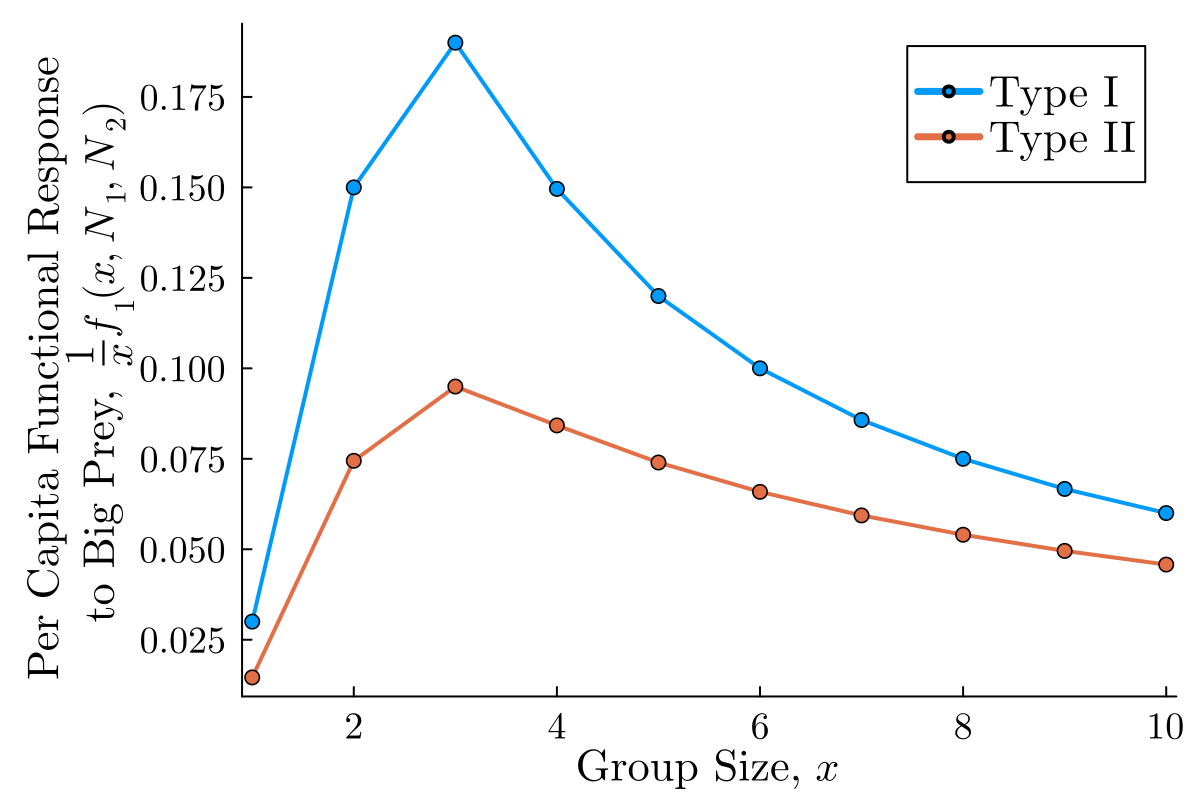

In [331]:
# type I
params1 = deepcopy(params_base)
params1[:scale] = 1.8
params1 = scale_parameters(params1)


# type II
params2 = deepcopy(params_base)
params2[:H2b] = 1.0
params2[:scale] = 1.8
params2 = scale_parameters(params2)


# plot f1/x vs group size for type I, type 2
groupsizes = 1:10
N1 = 1; N2 = 1.0

plt = plot(groupsizes,fun_f1(groupsizes,N1,N2,params1) ./ groupsizes, marker = :dot, label = "Type I")
plot!(groupsizes, fun_f1(groupsizes,N1,N2,params2) ./ groupsizes, marker = :dot, label = "Type II")

plot!(
    ylabel = "Per Capita Functional Response \nto Big Prey, " *L"\frac{1}{x} f_1(x,N_1,N_2)",
    xlabel = L"Group Size, $x$",
    left_margin = 5mm,
    xlim = [0.9,10.1]
    )

savefig(plt, bif_fig_path*"pc_funresonse_Varyx_Scale1_8.pdf")


plt



### Type I

0.0hi

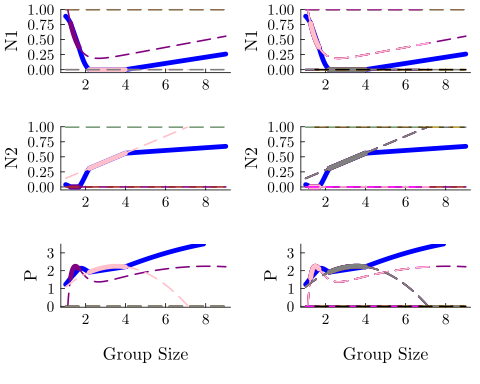

In [327]:
params = deepcopy(params_base)
params[:scale]=1.8
p_nt = NamedTuple(scale_parameters(params))


br_list, extra_branches = diagram_2_recursion_nog(
    p_nt; paramkey = :x, p_min = 1.01, p_max = 9.0, lens = (@optic _.x));
    
print(p_nt.H2b)
plot_comparison_branches_filtered(
    br_list, [br_list...,extra_branches...], :x;
     ymax = 3.5,has_g = false)
plot!(dpi=80)

Extra branches unnecessary

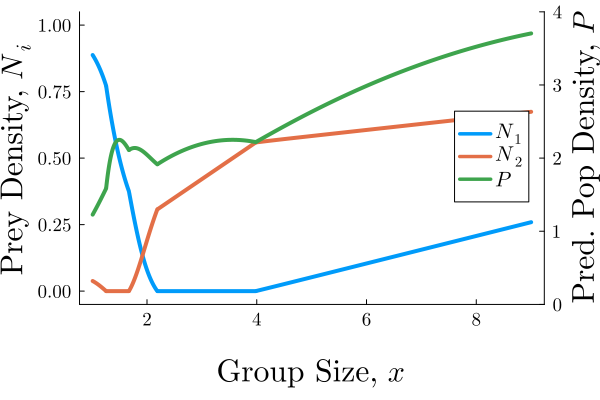

In [329]:
plt_N = plot_STABLE_lines(br_list; y2lims = [0,4])
savefig(plt_N, bif_fig_path*"stable_Varyx_T1_Scale1_8.pdf")



plt_N
plot!(dpi=100)

### Type II

(A1 = 0.6, η1 = 0.3333333333333333, H2b = 0.0, scale = 1.8, s1 = 2.0, H1a = 0.0, H2a = 0.0, α2_of_1 = 0.95, η2 = 0.6, x = 5.0, α1_of_1 = 0.05, β1 = 1.8, H1b = 0.0, A2 = 0.5, β2 = 1.0)hi

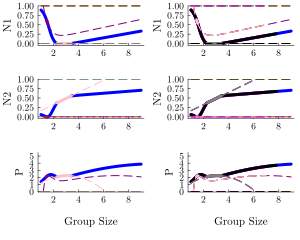

In [325]:
params = deepcopy(params_base)
params[:H2b] = 1.0
params[:scale]=1.8

p_nt2 = NamedTuple(scale_parameters(params))

print(p_nt)
br_list, extra_branches = diagram_2_recursion_nog(
    p_nt2; p_min = 1.01, p_max = 9.0, lens = (@optic _.x), paramkey = :x);
#plot_comparison_branches(br_list, extra_branches; ymax = 3.5)

plot_comparison_branches_filtered(
    br_list, [br_list...,extra_branches...], :x;
     ymax = 5.5,has_g = false)
plot!(dpi = 50)

hi

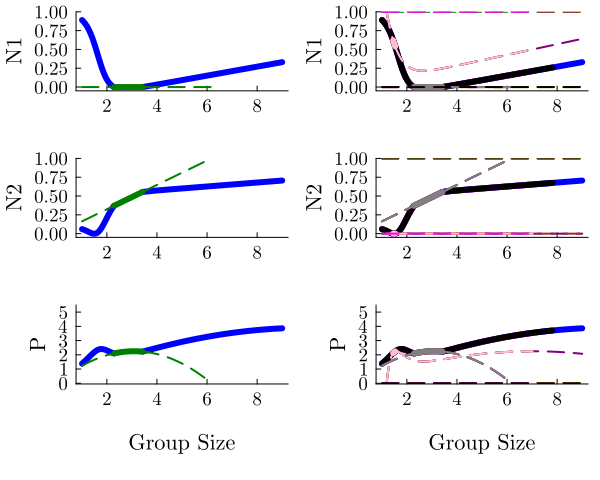

In [117]:
plot_comparison_branches_filtered(
    [br_list[:coexist], br_list[:N1_extinct]], [br_list...,extra_branches...], :x;
     ymax = 5.5,has_g = false)
plot!(dpi=100)

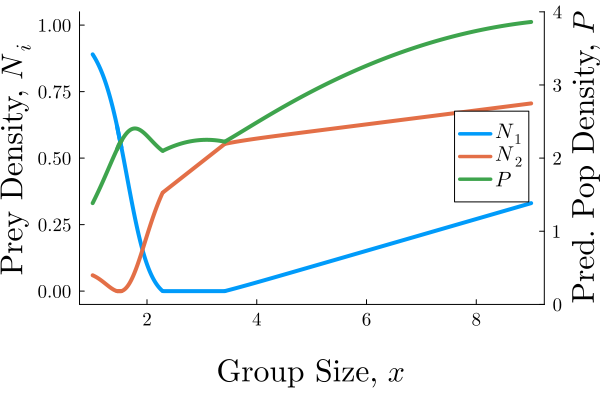

In [326]:
plt_N = plot_STABLE_lines(br_list; y2lims = [0,4])
savefig(plt_N, bif_fig_path*"stable_Varyx_T2_Scale1_8_H_1.pdf")

plt_N
plot!(dpi = 100)

### Type II bigger H

(A1 = 0.6, η1 = 0.3333333333333333, H2b = 0.0, scale = 1.8, s1 = 2.0, H1a = 0.0, H2a = 0.0, α2_of_1 = 0.95, η2 = 0.6, x = 5.0, α1_of_1 = 0.05, β1 = 1.8, H1b = 0.0, A2 = 0.5, β2 = 1.0)hi

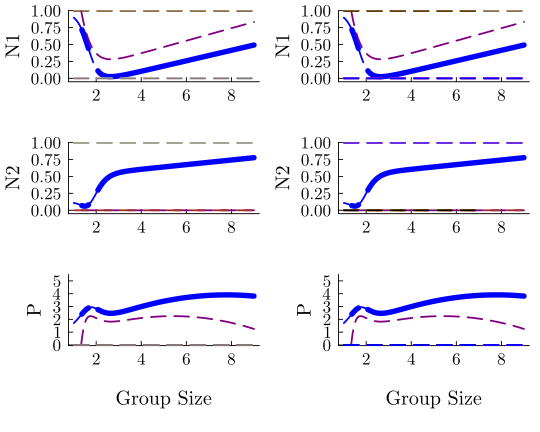

In [242]:
params = deepcopy(params_base)
params[:H2b] = 2.5
params[:scale]=1.8

p_nt2 = NamedTuple(scale_parameters(params))

print(p_nt)
br_list, extra_branches = diagram_2_recursion_nog(
    p_nt2; p_min = 1.01, p_max = 9.0, lens = (@optic _.x), paramkey = :x);
#plot_comparison_branches(br_list, extra_branches; ymax = 3.5)

plot_comparison_branches_filtered(
    br_list, [br_list...,extra_branches...], :x;
     ymax = 5.5,has_g = false)
plot!(dpi = 90)

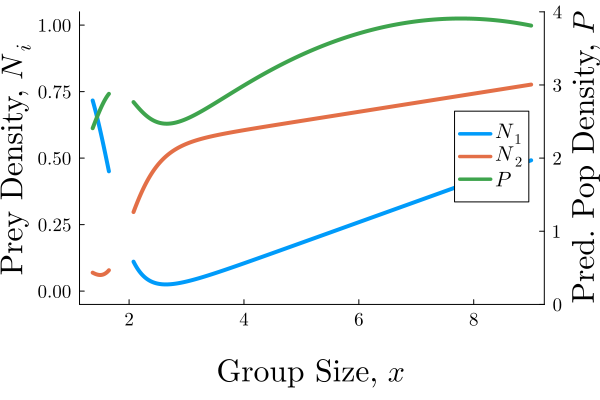

In [302]:
plt_N = plot_STABLE_lines([br_list[:coexist]]; y2lims = [0,4])
savefig(plt_N, bif_fig_path*"stable_Varyx_T1_Scale1_8_H_2_5.pdf")

plt_N
plot!(dpi = 100)

In [ ]:
N1, N2, P = hcat(sol.u...)

1×97 adjoint(::Vector{Vector{Float64}}) with eltype LinearAlgebra.Adjoint{Float64, Vector{Float64}}:
 [0.9 0.8 2.0]  [0.890347 0.795724 2.02501]  …  [0.042418 0.0663769 1.92148]

In [296]:
7.5+16.5 - 1.5

22.5

#### Simulation of Cycling

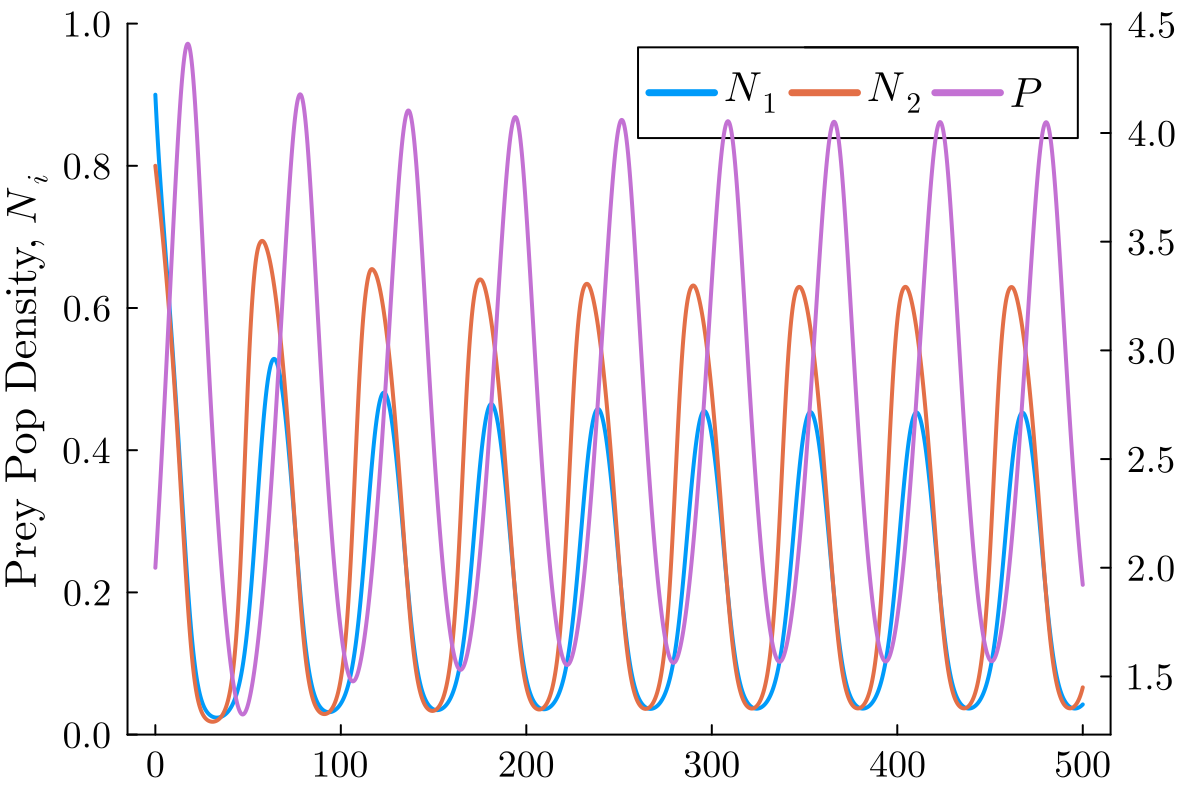

In [301]:
p_nt_sim = (p_nt2..., x = 2.0)
tspan = (0,500)
u0 = [0.9,0.8,2.0] # N1, N2, P
prob = ODEProblem(system_scaled_nogroups!, u0, tspan, p_nt_sim)
sol = solve(prob)

# get smooth (dense) series
t = range(first(sol.t), last(sol.t), length=2000)
N1 = sol(t; idxs=1).u
N2 = sol(t; idxs=2).u
P  = sol(t; idxs=3).u

plot(t, N1, label = L"N_1")
plot!(t, N2, label = L"N_2")

color_P = 4

plot!([],[], color = color_P, label = L"P")
plot!(
    ylabel = L"Prey Pop Density, $N_i$",
    ylims = [0,1])
plot!(
    twinx(),t,P, color = color_P, label = nothing,
    )
plot!(legendcolumns =3)

In [283]:
t

0.0:0.25012506253126565:500.0

## Scale 5

### Per Capita Functional Response to big Prey
Refer to this to explain results

In [7]:
# type I
params1 = deepcopy(params_base)
params1[:scale] = 5.0
params1 = scale_parameters(params1)


# type II
params2 = deepcopy(params_base)
params2[:H1a] = params[:H2a] = 0.0
params2[:H2b] = 1.0
params2[:scale] = 5.0
params2 = scale_parameters(params2)


# plot f1/x vs group size for type I, type 2
groupsizes = 1:10
N1 = 1; N2 = 1.0

plt = plot(groupsizes,fun_f1(groupsizes,N1,N2,params1) ./ groupsizes, marker = :dot, label = "Type I")
plot!(groupsizes, fun_f1(groupsizes,N1,N2,params2) ./ groupsizes, marker = :dot, label = "Type II")

plot!(
    ylabel = "Per Capita Functional Response \nto Big Prey, " *L"\frac{1}{x} f_1(x,N_1,N_2)",
    xlabel = L"Group Size, $x$",
    left_margin = 5mm,
    xlim = [0.9,10.1]
    )

savefig(plt, bif_fig_path*"pc_funresonse_Varyx_Scale5.pdf")


plt



UndefVarError: UndefVarError: `params` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Distributions in the current active module Main

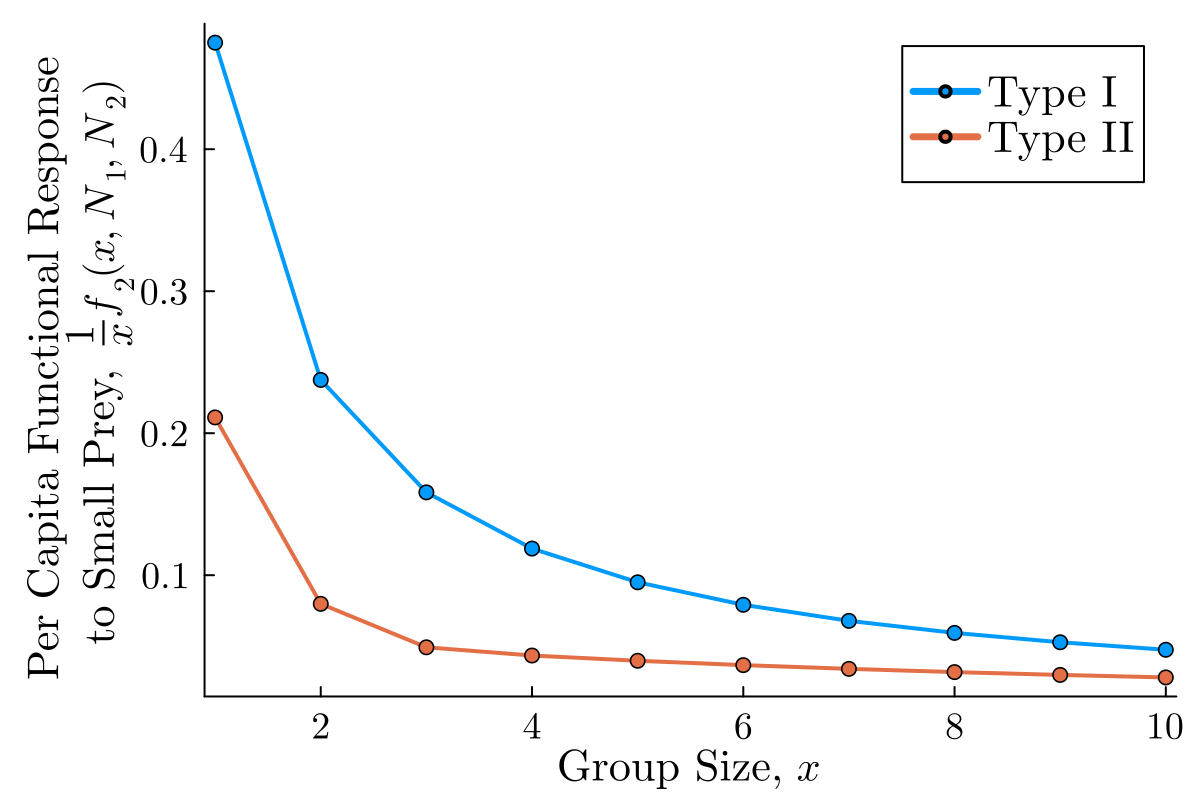

In [64]:
# type I
params1 = deepcopy(params_base)
params1[:scale] = 5.0
params1 = scale_parameters(params1)


# type II
params2 = deepcopy(params_base)
params2[:H1a] = params[:H2a] = 0.0
params2[:H2b] = 1.0
params2[:scale] = 5.0
params2 = scale_parameters(params2)


# plot f1/x vs group size for type I, type 2
groupsizes = 1:10
N1 = 1; N2 = 1.0

plt = plot(groupsizes,fun_f2(groupsizes,N1,N2,params1) ./ groupsizes, marker = :dot, label = "Type I")
plot!(groupsizes, fun_f2(groupsizes,N1,N2,params2) ./ groupsizes, marker = :dot, label = "Type II")

plot!(
    ylabel = "Per Capita Functional Response \nto Small Prey, " *L"\frac{1}{x} f_2(x,N_1,N_2)",
    xlabel = L"Group Size, $x$",
    left_margin = 5mm,
    xlim = [0.9,10.1]
    )

#savefig(plt, bif_fig_path*"pc_funresonse_Varyx_Scale5.pdf")


plt



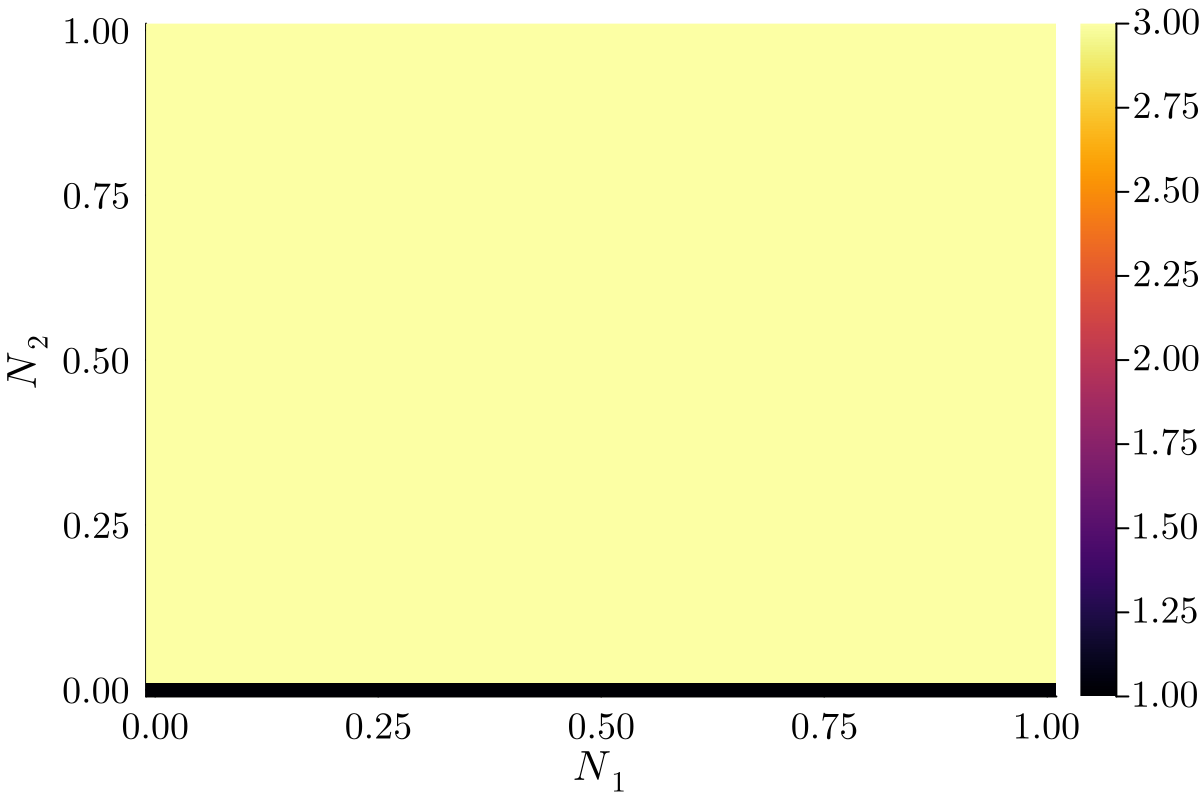

In [62]:
n = 50
params_use = params2
x_max = 10


groupsizes = 1:x_max
N1_grid = range(0,1.0, length = n)
N2_grid = deepcopy(N1_grid)
x_opt_mat = Array{Float64}(undef, n, n)

for (ix, N1_val) in enumerate(N1_grid)
    for (iy, N2_val) in enumerate(N2_grid)
        pc_f = fun_f1(1:x_max, N1_val,N2_val,params_use) ./ groupsizes
        x_opt = findmax(pc_f)[2]
        x_opt_mat[ix,iy] = x_opt
    end
end
hm = heatmap(
    N1_grid,
    N2_grid,
    x_opt_mat,
    xlabel = L"N_1",
    ylabel = L"N_2"
)


In [49]:
find_x_maximizes_pc_f(10,1,0.5,params1)

3

In [8]:
methods(fun_f1)

# 1 method for generic function "fun_f1" from CooperativeHuntingPkg.ModelHelperFuns:
 [1] fun_f1(x, N1, N2, parameters)
     @ ~/Documents/CH_GroupFormation/CH_code/Julia_version/CooperativeHuntingPkg/src/ModelHelperFuns.jl:80

### Type I

[0.3253222182033871, 0.8931579718077899, 0.6748117958402625][1.0, 1.0, 0.0][0.46680793159925915, 0.0, 0.5340539806798477][0.0, 0.9998837095251152, 1.0e-323][0.9999272908521222, 0.0, 0.0][0.0, 0.9995870930963856, 0.0][1.0000000071579465, 0.0, -1.5350261970742343e-8][0.0, 1.0000000000000002, 1.0e-323][1.0, 0.0, 0.0][0.0, 1.000000000000029, 0.0]hi

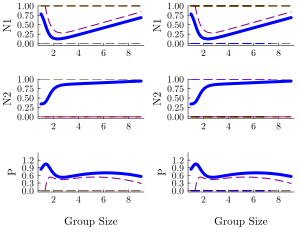

In [9]:
params = deepcopy(params_base)
params[:scale] = 5.0
p_nt = NamedTuple(scale_parameters(params))
br_list, extra_branches = diagram_2_recursion_nog(
    p_nt; p_min = 1.01, p_max = 9.0, lens = (@optic _.x),
    paramkey = :x);
plot_comparison_branches_filtered(
    br_list, [br_list...,extra_branches...], :x;
     ymax = 1.5,has_g = false)
plot!(dpi = 50)

In [10]:
branch_struc = br_list[:coexist].branch
param_P_list = [[br.param, br.N1] for br in branch_struc];
param_P_list = hcat(param_P_list...)
col_max = argmax(param_P_list[2, :])
x_max_P = param_P_list[1,col_max]

col_min = argmin(param_P_list[2, :])
x_min_P = param_P_list[1,col_min]

2.347193637593284

In [50]:
xs  = collect(1:9)
N1s = Float64[]
N2s = Float64[]
Ps  = Float64[]

for x in xs
    params_x = scale_parameters(deepcopy(params))
    params_x[:x] = x
    u_eq = equilibrium_nogroups(params_x)
    N1, N2, P = u_eq
    if P > 0
        push!(N1s, N1)
        push!(N2s, N2)
        push!(Ps,  P)
    else:
        push!(N1s,1)
        push!(N2s,1)
        push!(Ps, 0)
    end
end
#--- Plot ---
plot!(xs, N1s, seriestype = :scatter, color = 1, label = "")


Base.Meta.ParseError: ParseError:
# Error @ /Users/taliaborofsky/Documents/CH_GroupFormation/CH_code/Julia_version/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y105sZmlsZQ==.jl:15:10
        push!(Ps,  P)
#        ┌
    else:
        push!(N1s,1)
#──────┘ ── whitespace not allowed after `:` used for quoting

In [47]:
function scatter_equilibria_vs_x(x_max,params)
    xs  = collect(1:9)
    N1s = Float64[]
    N2s = Float64[]
    Ps  = Float64[]
    for x in xs
        params_x = scale_parameters(deepcopy(params))
        params_x[:x] = x
        u_eq = equilibrium_nogroups(params_x)
        N1, N2, P = u_eq
        push!(N1s, N1)
        push!(N2s, N2)
        push!(Ps,  P)
    end
    #--- Plot ---
    plot!(xs, N1s, seriestype = :scatter, color = 1, label = "")
    scatter!(xs, N2s,
        color = 2,
        label = ""
    )

    scatter!( 
        xs, Ps,
        color = 3,
        label = ""
    )
end

scatter_equilibria_vs_x (generic function with 1 method)

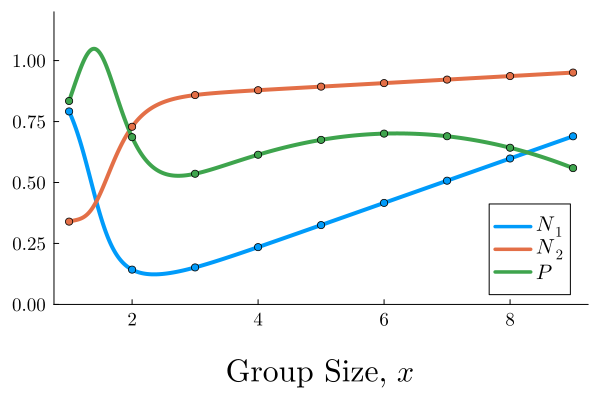

In [ ]:
plt_N = plot_STABLE_lines(br_list[:coexist]; twinx = false, y2lims = [0,1.2])


scatter_equilibria_vs_x(9,params)
plot!(legend=:bottomright)
savefig(plt_N, bif_fig_path*"stable_Varyx_T1_Scale5.pdf")

plt_N

plot!(dpi = 100)

In [ ]:
branches_keep = [br_list..., extra_branches[1]];
#plot_nice_bif(branches_keep, :N1, :x, has_g = false)
plt_nt = make_and_save_nice_plots(
        branches_keep, "Varyx_T1_Scale5"; param_key = :x, has_g = false,
        P_lims = [-0.05,1.5]
        )

(P = Plot{Plots.GRBackend() n=7}, N1 = Plot{Plots.GRBackend() n=7}, N2 = Plot{Plots.GRBackend() n=7}, Nsum = Plot{Plots.GRBackend() n=7})

### Type II

In [40]:
params = deepcopy(params_base)
params[:H1a] = params[:H2a] = 0.0
params[:H2b] = 1.0
params[:scale] = 5.0
p_nt = NamedTuple(scale_parameters(params))

br_list, extra_branches = diagram_2_recursion_nog(
    p_nt; p_min = 1.01, p_max = 9.0, lens = (@optic _.x),
    paramkey = :x);
#plot_comparison_branches(br_list, extra_branches; ymax = 1.5)


[0.921759224194092, 0.9873972936826387, 0.18321362784131717][1.0, 1.0, 0.0][0.9997374659621333, 0.0, 1.182893162366504e-33][0.0, 0.9999074781224491, 1.0e-323][0.9999272908521222, 0.0, 0.0][0.0, 0.9995870930963856, 0.0][1.0000069286297575, 1.0000086323686834, -3.334526166310769e-5][1.000000018207948, 1.0000000028830334, -4.519787807241741e-8][1.0, 1.0, 0.0][1.0, 1.0, 0.0][1.0000000000000047, 0.0, -6.167478856696476e-42][1.0000000000000047, 0.0, -6.167478856696476e-42][1.0, 0.0, 0.0][1.0, 0.0, 0.0]

((coexist =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 622
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter x starts at 1.01, ends at 9.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at x ≈ +1.01000000,                                                                     step =   0
- #  2,       bp at x ≈ +1.34554815 ∈ (+1.34552710, +1.34554815), |δp|=2e-05, [    guess], δ = (-1,  0), step =  27
- #  3,       bp at x ≈ +5.46053727 ∈ (+5.46053707, +5.46053727), |δp|=2e-07, [converged], δ = ( 1,  0), step = 339
- #  4, endpoint at x ≈ +9.00000000,                                                                     step = 621
, predator_extinct =  ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 569
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter x starts at 1.01, ends at 9.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at x ≈ +1.01000000,                                                                     step =   0
- #  2,       bp at x ≈ +1.34556737 ∈

hi

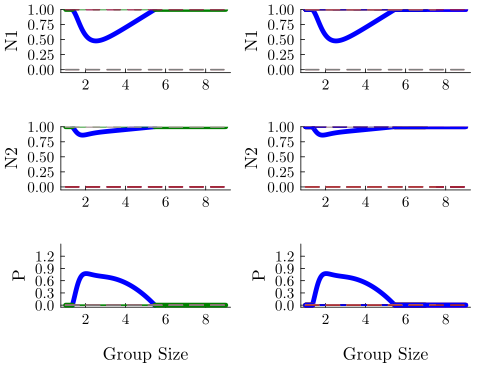

In [41]:
plot_comparison_branches_filtered(
    br_list, [br_list...,extra_branches...], :x;
     ymax = 1.5,has_g = false)
plot!(dpi=80)

In [39]:
branches_keep = br_list; # no need for extra stuff
#plot_nice_bif(branches_keep, :N1, :x, has_g = false)
plt_nt = make_and_save_nice_plots(
        branches_keep, "Varyx_T2_Scale5"; param_key = :x, has_g = false,
        P_lims = [-0.05,1.5]
        )


(P = Plot{Plots.GRBackend() n=8}, N1 = Plot{Plots.GRBackend() n=8}, N2 = Plot{Plots.GRBackend() n=8}, Nsum = Plot{Plots.GRBackend() n=8})

#### make a plot of P, N1, N2 on same plot

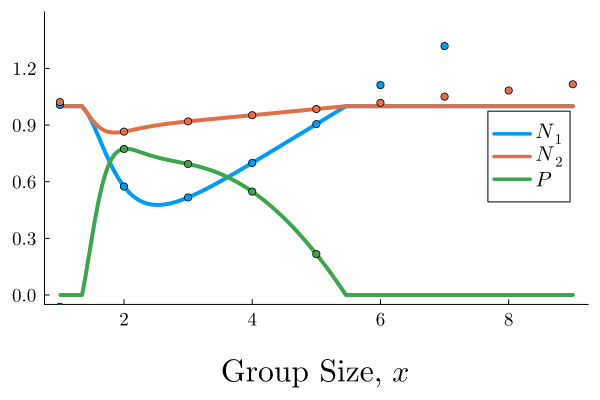

In [53]:
params = deepcopy(params_base)
params[:H1a] = params[:H2a] = 0.0
params[:H2b] = 1.0
params[:scale] = 5.0

plt_N = plot_STABLE_lines(br_list[:coexist]; twinx=false, y2lims = [-0.05,1.5])
scatter_equilibria_vs_x(9,params)

savefig(plt_N, bif_fig_path*"stable_Varyx_T2_Scale5.pdf")

plt_N
plot!(dpi = 100)

# Scale 8

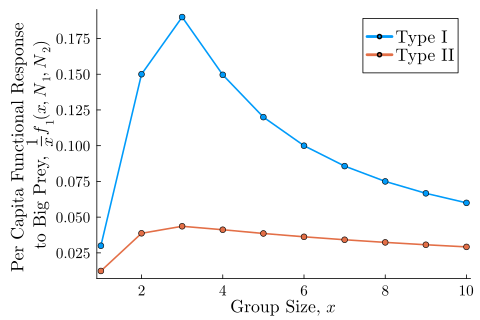

In [333]:
# type I
params1 = deepcopy(params_base)
params1[:scale] = 8.0
params1 = scale_parameters(params1)


# type II
params2 = deepcopy(params_base)
params2[:H2b] = 1.0
params2[:scale] = 8.0
params2 = scale_parameters(params2)


# plot f1/x vs group size for type I, type 2
groupsizes = 1:10
N1 = 1; N2 = 1.0

plt = plot(groupsizes,fun_f1(groupsizes,N1,N2,params1) ./ groupsizes, marker = :dot, label = "Type I")
plot!(groupsizes, fun_f1(groupsizes,N1,N2,params2) ./ groupsizes, marker = :dot, label = "Type II")

plot!(
    ylabel = "Per Capita Functional Response \nto Big Prey, " *L"\frac{1}{x} f_1(x,N_1,N_2)",
    xlabel = L"Group Size, $x$",
    left_margin = 5mm,
    xlim = [0.9,10.1]
    )

savefig(plt, bif_fig_path*"pc_funresonse_Varyx_Scale8.pdf")

plot!(dpi = 80)
plt



0.0hi

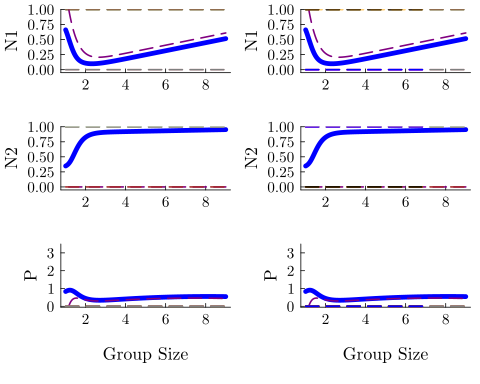

In [334]:
params = deepcopy(params_base)
params[:scale]=8.0
p_nt = NamedTuple(scale_parameters(params))

br_list, extra_branches = diagram_2_recursion_nog(
    p_nt; paramkey = :x, p_min = 1.01, p_max = 9.0, lens = (@optic _.x));
    
print(p_nt.H2b)
plot_comparison_branches_filtered(
    br_list, [br_list...,extra_branches...], :x;
     ymax = 3.5,has_g = false)
plot!(dpi=80)

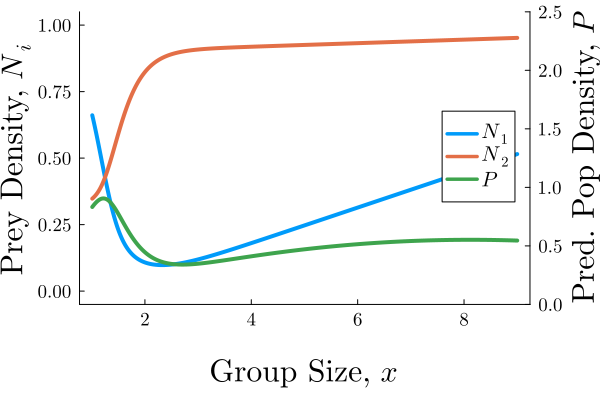

In [335]:
plt_N = plot_STABLE_lines(br_list)
savefig(plt_N, bif_fig_path*"stable_Varyx_T1_Scale8.pdf")

plt_N
plot!(dpi = 100)

1.0hi

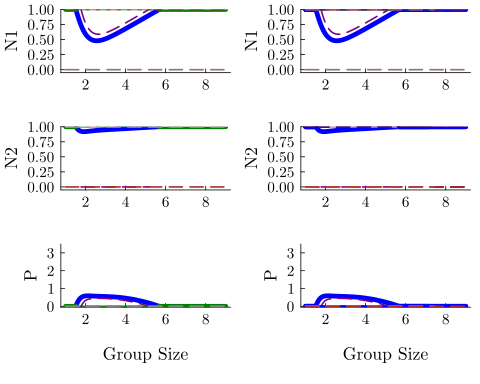

In [336]:
params = deepcopy(params_base)
params[:scale]=8.0
params[:H2b] = 1.0
p_nt = NamedTuple(scale_parameters(params))

br_list, extra_branches = diagram_2_recursion_nog(
    p_nt; paramkey = :x, p_min = 1.01, p_max = 9.0, lens = (@optic _.x));
    
print(p_nt.H2b)
plot_comparison_branches_filtered(
    br_list, [br_list...,extra_branches...], :x;
     ymax = 3.5,has_g = false)
plot!(dpi=80)



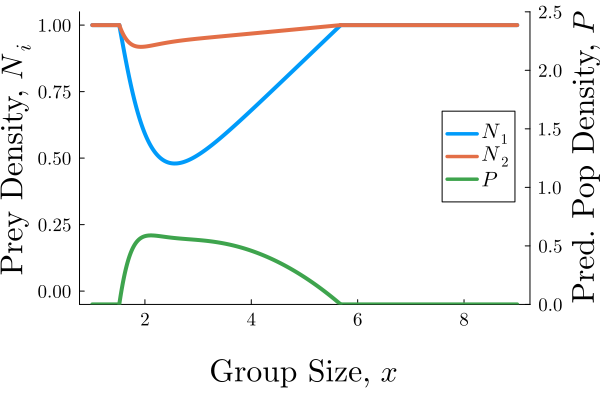

In [337]:
plt_N = plot_STABLE_lines(br_list)
savefig(plt_N, bif_fig_path*"stable_Varyx_T2_Scale8.pdf")

plt_N
plot!(dpi = 100)

plot_sim (generic function with 1 method)

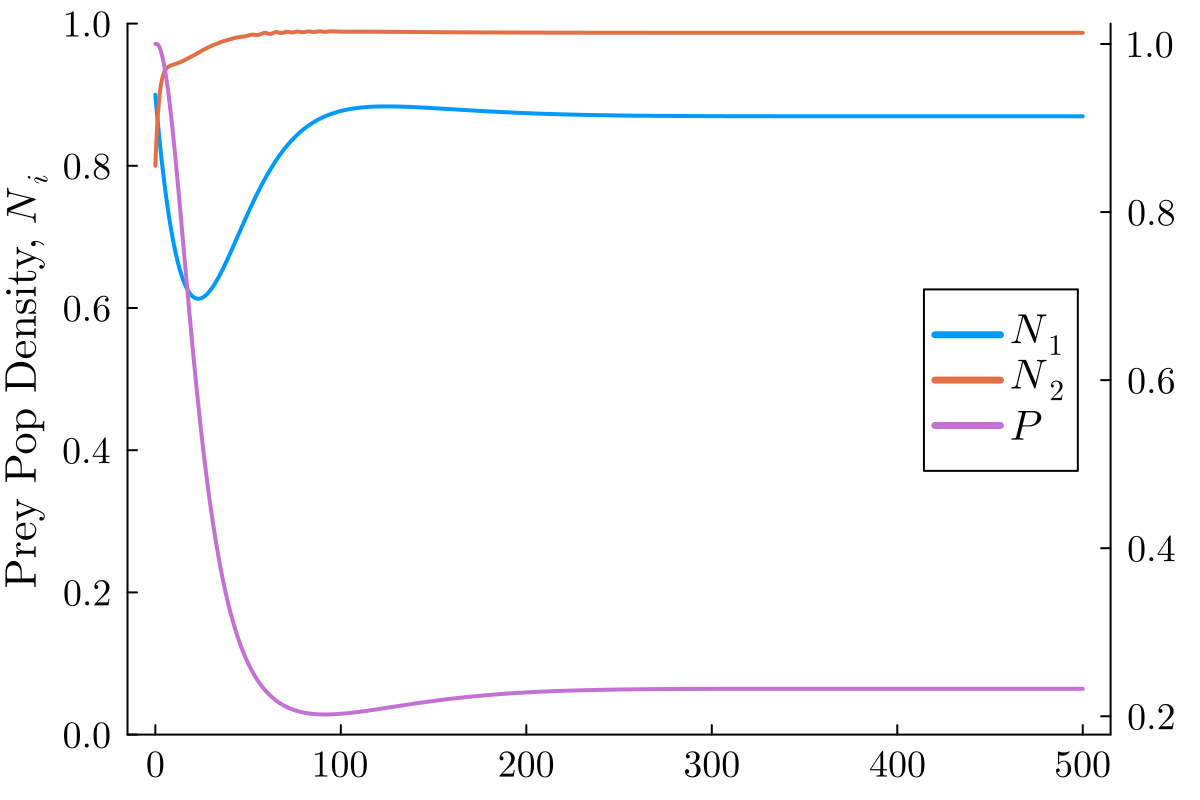

In [320]:
plot_sim(5.0, p_nt; u0 = [0.9,0.8,1.0], tspan = (0,500))

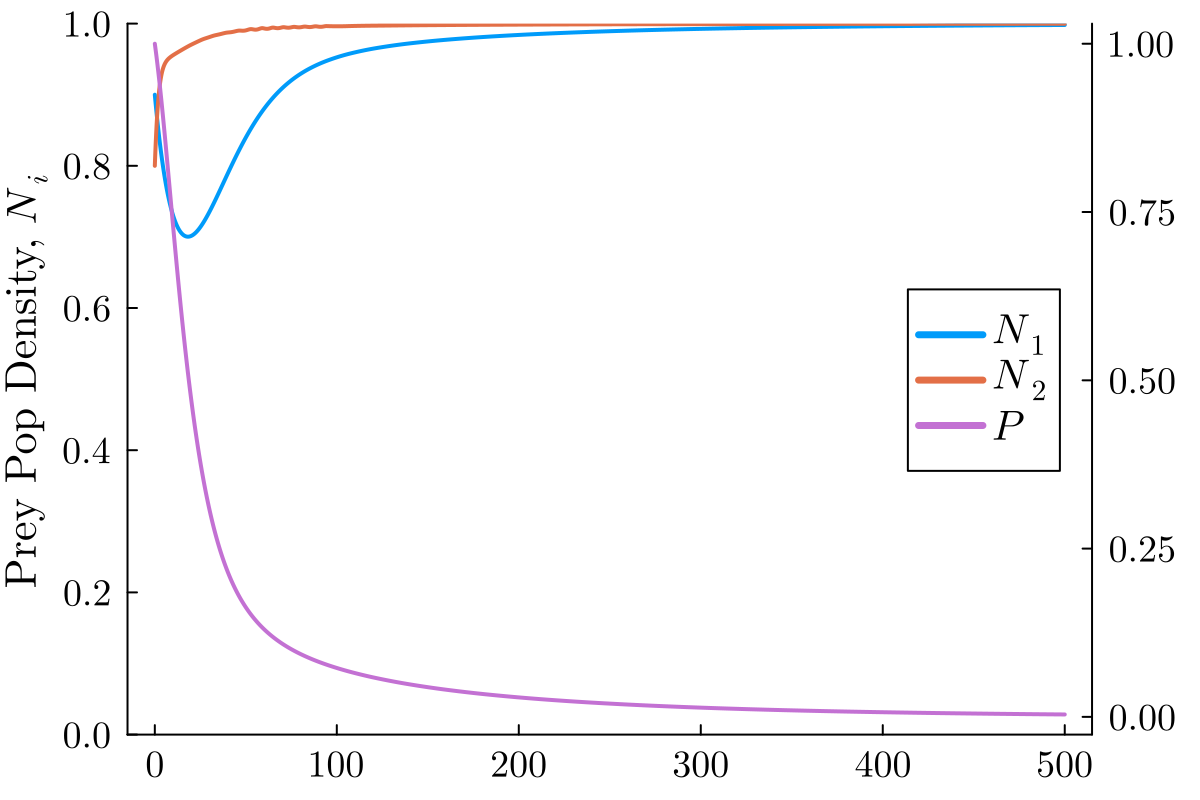

In [322]:
plot_sim(6.0, p_nt; u0 = [0.9,0.8,1.0], tspan = (0,500))

Could calculate prey population on which it can sustain itself???